# 猫狗大战毕业项目

## 探索性可视化

In [1]:
from os import listdir
from os.path import isfile, join
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
import cv2

%matplotlib inline

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


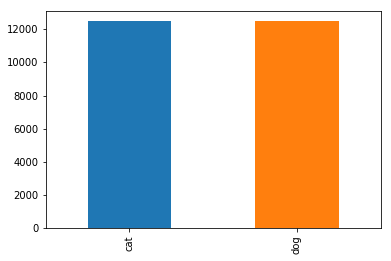

In [2]:
img_files = [f for f in listdir('./train') if isfile(join('./train', f))]
img_data = defaultdict(list)
for img_file in img_files:
    img_data[img_file[:3]].append(img_file)

img_data = pd.DataFrame(img_data)
img_data = pd.Series([img_data['cat'].count(), img_data['dog'].count()], index=['cat', 'dog'])
img_data.plot(kind='bar')

训练集中猫和狗的图片各占一半，分别为12500张。

## 数据预处理

通过研究[清单](https://gist.github.com/aaronpolhamus/964a4411c0906315deb9f4a3723aac57)可以知道ImageNet的1000种分类中狗和猫对应的标签，可以根据这个信息快速构建自己的异常值检测器。

In [31]:
from keras.applications.xception import Xception
from keras.applications.xception import preprocess_input as xception_preprocess
from keras.applications.xception import decode_predictions as xception_decode

from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input as inception_preprocess
from keras.applications.inception_v3 import decode_predictions as inception_decode

from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input as resnet_preprocess
from keras.applications.resnet50 import decode_predictions as resnet_decode

from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input as vgg16_preprocess
from keras.applications.vgg16 import decode_predictions as vgg16_decode

from keras.preprocessing import image

In [32]:
dogs = [
    'n02085620','n02085782','n02085936','n02086079', 
    'n02086240','n02086646','n02086910','n02087046',
    'n02087394','n02088094','n02088238','n02088364',
    'n02088466','n02088632','n02089078','n02089867',
    'n02089973','n02090379','n02090622','n02090721',
    'n02091032','n02091134','n02091244','n02091467',
    'n02091635','n02091831','n02092002','n02092339',
    'n02093256','n02093428','n02093647','n02093754',
    'n02093859','n02093991','n02094114','n02094258',
    'n02094433','n02095314','n02095570','n02095889',
    'n02096051','n02096177','n02096294','n02096437',
    'n02096585','n02097047','n02097130','n02097209',
    'n02097298','n02097474','n02097658','n02098105',
    'n02098286','n02098413','n02099267','n02099429',
    'n02099601','n02099712','n02099849','n02100236',
    'n02100583','n02100735','n02100877','n02101006',
    'n02101388','n02101556','n02102040','n02102177',
    'n02102318','n02102480','n02102973','n02104029',
    'n02104365','n02105056','n02105162','n02105251',
    'n02105412','n02105505','n02105641','n02105855',
    'n02106030','n02106166','n02106382','n02106550',
    'n02106662','n02107142','n02107312','n02107574',
    'n02107683','n02107908','n02108000','n02108089',
    'n02108422','n02108551','n02108915','n02109047',
    'n02109525','n02109961','n02110063','n02110185',
    'n02110341','n02110627','n02110806','n02110958',
    'n02111129','n02111277','n02111500','n02111889',
    'n02112018','n02112137','n02112350','n02112706',
    'n02113023','n02113186','n02113624','n02113712',
    'n02113799','n02113978']

cats = [
    'n02123045','n02123159','n02123394','n02123597',
    'n02124075','n02125311','n02127052',
]

In [33]:
np.random.RandomState(42).shuffle(img_files)

def abnormals_detect(detector, img_files, top, preprocess, decode):
    abnormals = []
    for img_file in img_files:
        img = image.load_img('./train/'+img_file, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess(x)

        preds = detector.predict(x)
        preds = decode(preds, top=top)
        dog_or_cat_found = False
        for pred in preds[0]:
            if pred[0] in dogs or pred[0] in cats:
                dog_or_cat_found = True
            
        if not dog_or_cat_found:
            abnormals.append(img_file)
    return abnormals

def display_image(img_paths):
    for path in img_paths:
        img = cv2.imread('./train/'+path)
        cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(cv_rgb)
        plt.show()


19 abnormals detected: ['dog.6988.jpg', 'cat.8484.jpg', 'cat.4842.jpg', 'cat.5433.jpg', 'cat.3802.jpg', 'cat.7545.jpg', 'dog.59.jpg', 'cat.12146.jpg', 'cat.335.jpg', 'cat.520.jpg', 'cat.6442.jpg', 'cat.6590.jpg', 'cat.10859.jpg', 'cat.4430.jpg', 'cat.4492.jpg', 'cat.9695.jpg', 'dog.8627.jpg', 'cat.9693.jpg', 'cat.6676.jpg']


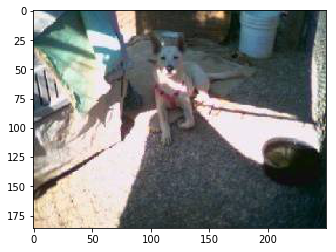

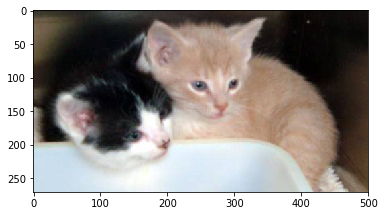

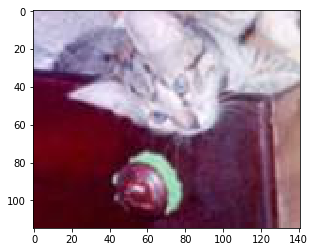

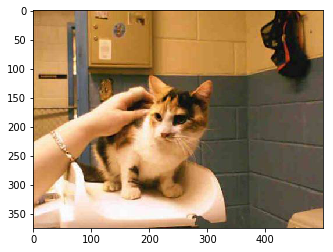

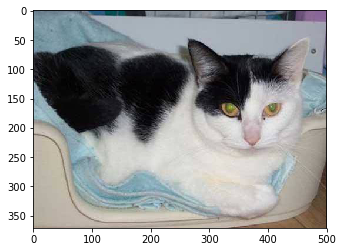

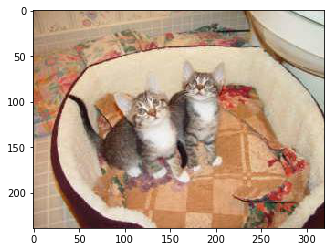

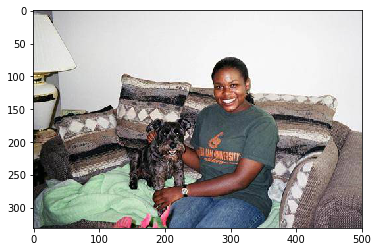

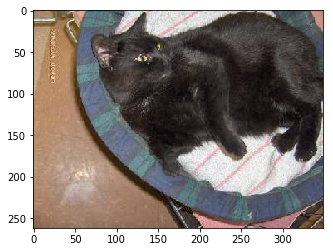

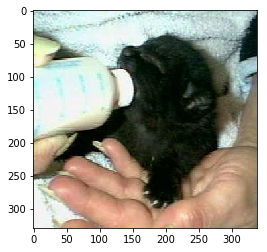

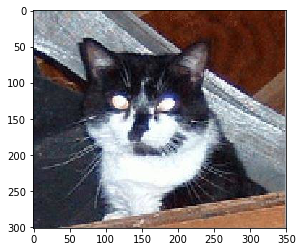

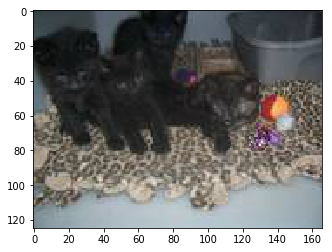

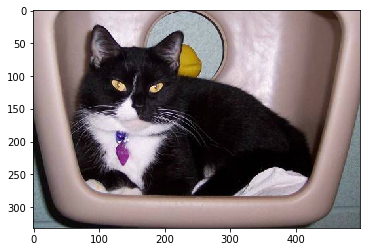

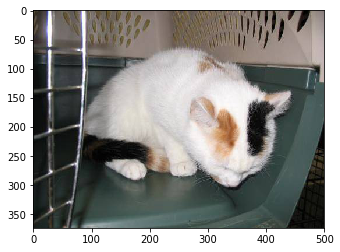

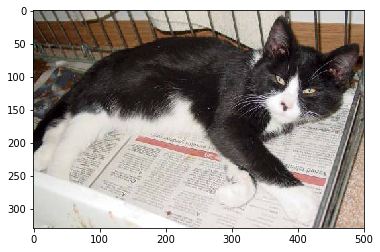

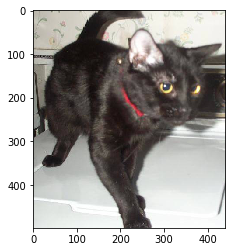

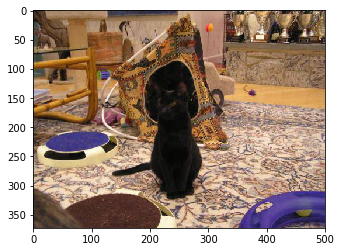

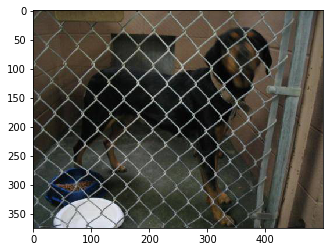

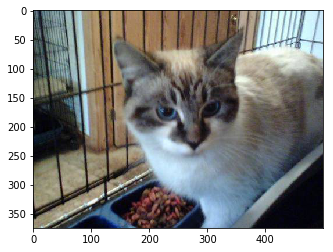

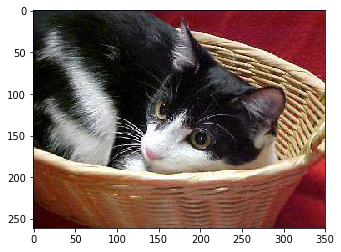

In [34]:
xception_detector = Xception(weights='imagenet')
xception_abnormals = abnormals_detect(xception_detector, img_files[:1000], 5, xception_preprocess, xception_decode)
print('{} abnormals detected: {}'.format(len(xception_abnormals), xception_abnormals))
display_image(xception_abnormals)

根据[Keras文档](https://keras.io/applications/)，准确率最高的模型是Xception，其Top-1和Top-5准确率分别为0.790和0.945。先以这个模型作为检测器，以1000张混洗过的图片作为样本，看看Top-5下都有哪些图片被识别为非猫非狗，检测出来有14张异常值，误报率较高，但的确也发现了 一些有问题的图片，比如有1张就是狗的卡通图片。下面将Top值提高到10看看。

11 abnormals detected: ['dog.6988.jpg', 'cat.4842.jpg', 'cat.7545.jpg', 'dog.59.jpg', 'cat.335.jpg', 'cat.6442.jpg', 'cat.6590.jpg', 'cat.10859.jpg', 'cat.4430.jpg', 'cat.9695.jpg', 'dog.8627.jpg']


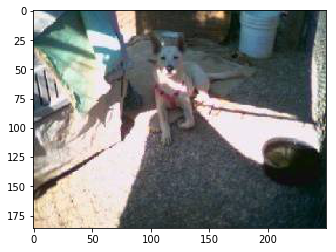

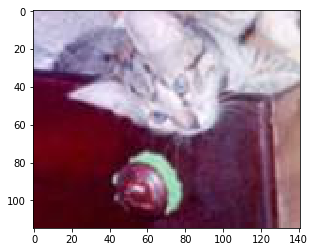

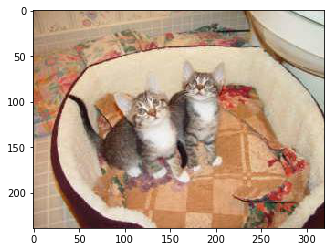

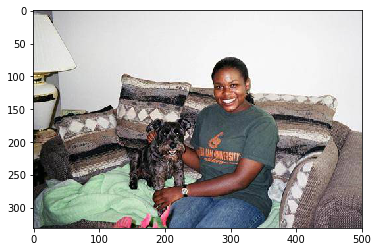

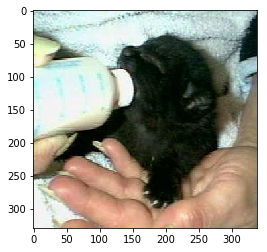

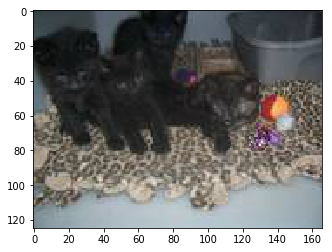

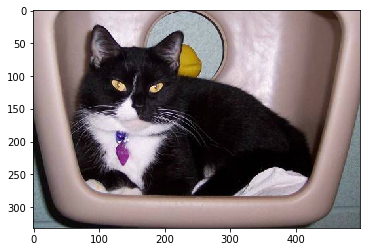

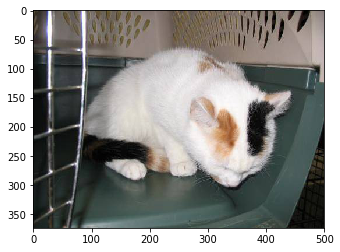

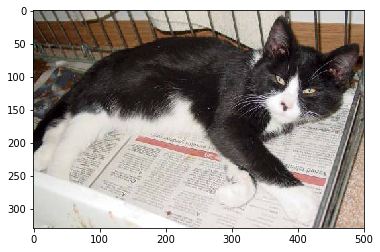

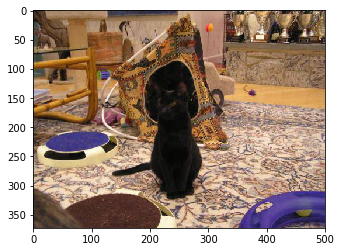

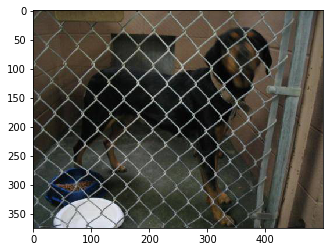

In [35]:
xception_abnormals = abnormals_detect(xception_detector, img_files[:1000], 10, xception_preprocess, xception_decode)
print('{} abnormals detected: {}'.format(len(xception_abnormals), xception_abnormals))
display_image(xception_abnormals)

误报率仍然比较高，下面再分别试验下Top-20和Top-30。

5 abnormals detected: ['dog.6988.jpg', 'cat.4842.jpg', 'cat.6442.jpg', 'cat.6590.jpg', 'cat.9695.jpg']


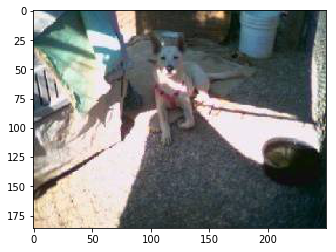

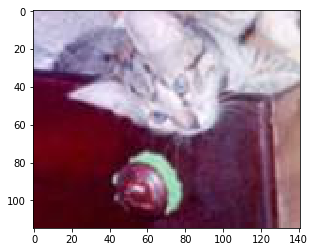

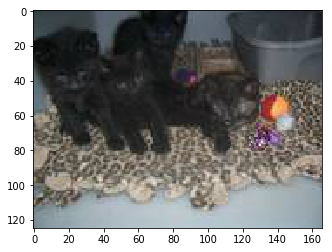

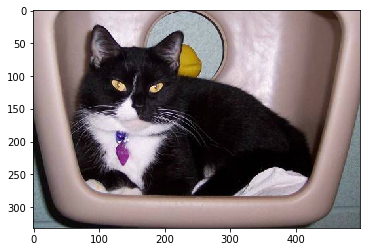

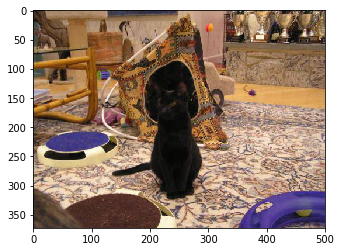

In [36]:
xception_abnormals = abnormals_detect(xception_detector, img_files[:1000], 20, xception_preprocess, xception_decode)
print('{} abnormals detected: {}'.format(len(xception_abnormals), xception_abnormals))
display_image(xception_abnormals)

2 abnormals detected: ['dog.6988.jpg', 'cat.4842.jpg']


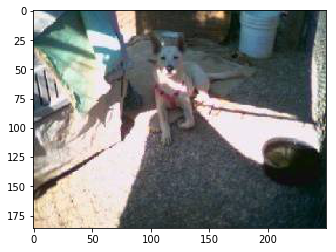

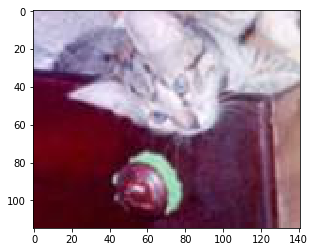

In [37]:
xception_abnormals = abnormals_detect(xception_detector, img_files[:1000], 30, xception_preprocess, xception_decode)
print('{} abnormals detected: {}'.format(len(xception_abnormals), xception_abnormals))
display_image(xception_abnormals)

从得到的结果可以看出Top值为30时检测到了2张图片，属于图片内容比较多或者比较模糊的，下面把样本数量提高到5000，再看看检测结果。

18 abnormals detected: ['dog.6988.jpg', 'cat.4842.jpg', 'cat.2433.jpg', 'cat.8470.jpg', 'cat.5351.jpg', 'cat.2975.jpg', 'cat.9520.jpg', 'cat.12424.jpg', 'dog.12376.jpg', 'cat.11237.jpg', 'dog.4565.jpg', 'cat.519.jpg', 'cat.6402.jpg', 'dog.10237.jpg', 'cat.5062.jpg', 'cat.4338.jpg', 'cat.3123.jpg', 'cat.7599.jpg']


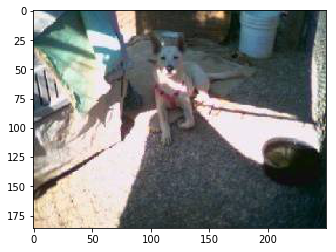

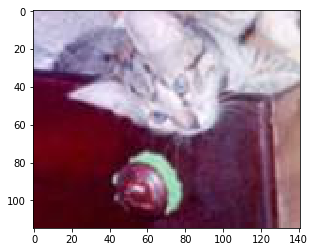

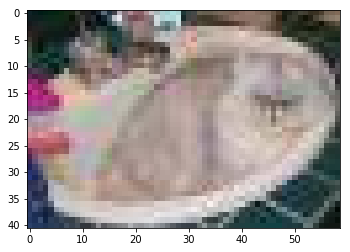

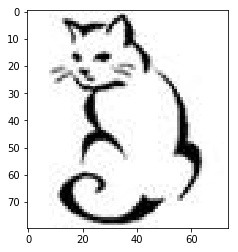

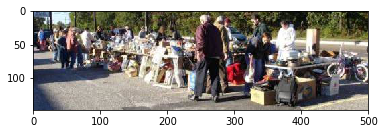

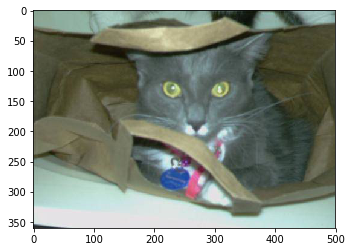

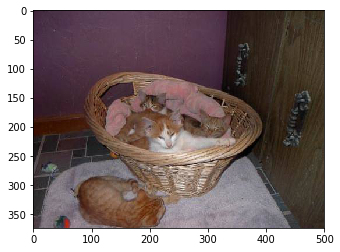

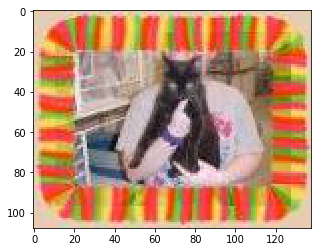

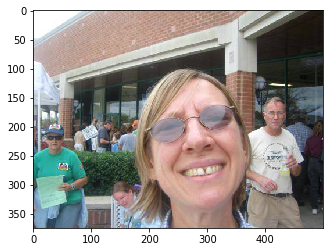

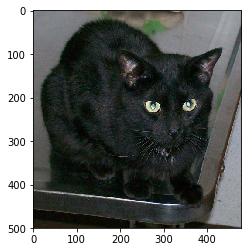

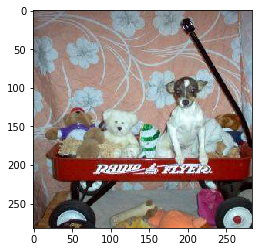

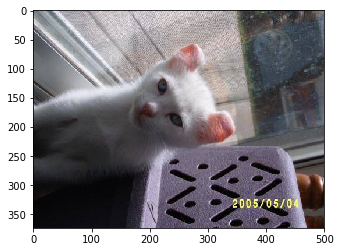

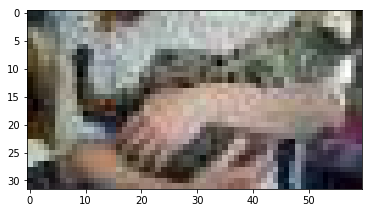

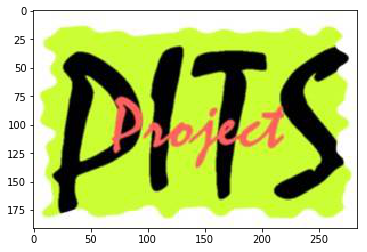

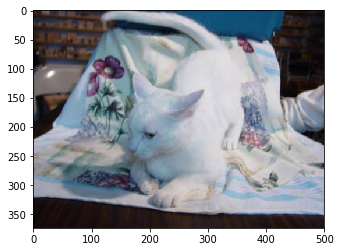

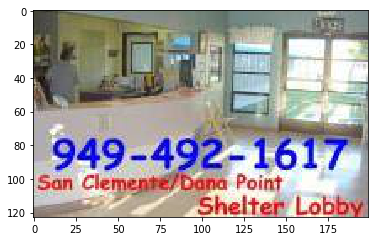

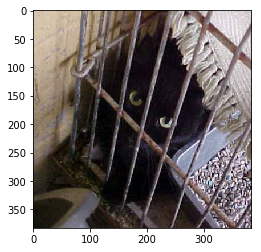

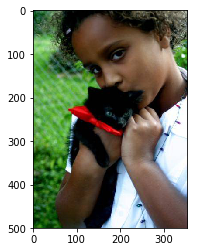

In [38]:
xception_abnormals = abnormals_detect(xception_detector, img_files[:5000], 30, xception_preprocess, xception_decode)
print('{} abnormals detected: {}'.format(len(xception_abnormals), xception_abnormals))
display_image(xception_abnormals)

上面5000个样本的检测结果显示的确有一些图片既不是猫也不是狗，但还是有一些正常的图片被误报了，不算太理想，把Top值提高到60，样本数量提高到10000再看看。

17 abnormals detected: ['cat.2433.jpg', 'cat.8470.jpg', 'cat.9520.jpg', 'cat.12424.jpg', 'cat.6402.jpg', 'cat.4338.jpg', 'dog.3341.jpg', 'dog.1773.jpg', 'cat.7564.jpg', 'dog.4367.jpg', 'cat.712.jpg', 'cat.8921.jpg', 'dog.10551.jpg', 'dog.10801.jpg', 'dog.8736.jpg', 'cat.5974.jpg', 'dog.8898.jpg']


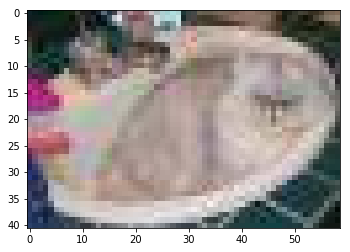

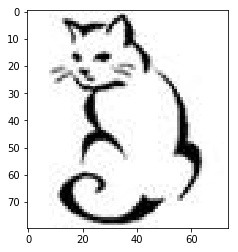

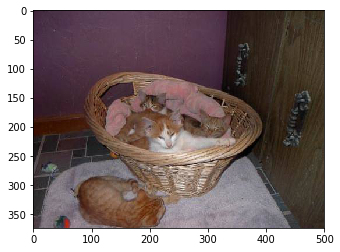

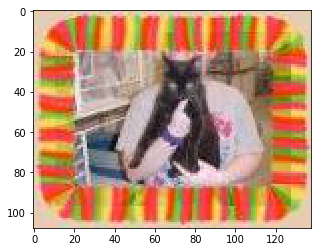

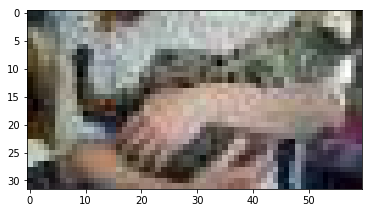

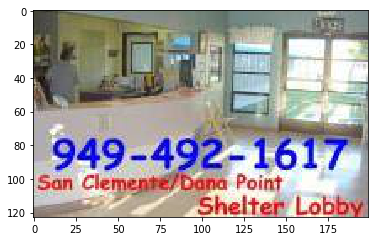

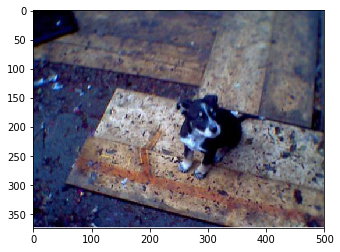

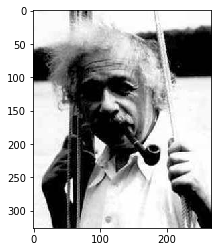

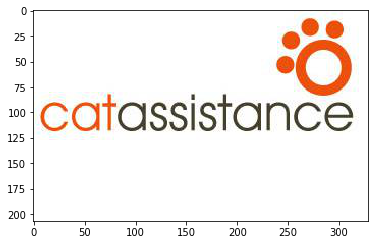

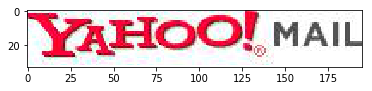

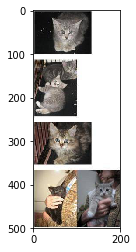

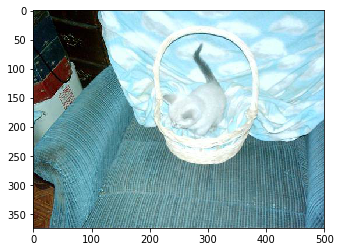

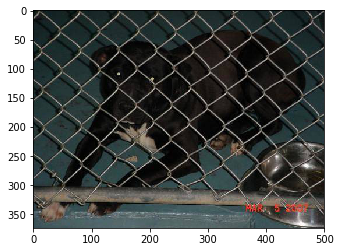

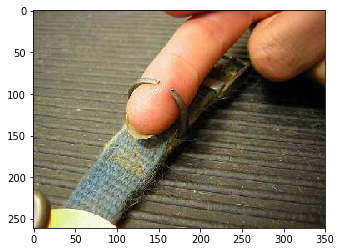

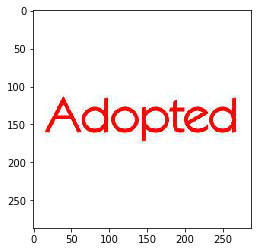

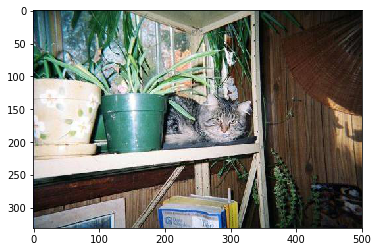

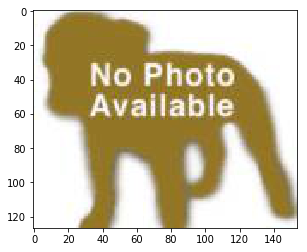

In [39]:
xception_abnormals = abnormals_detect(xception_detector, img_files[:10000], 60, xception_preprocess, xception_decode)
print('{} abnormals detected: {}'.format(len(xception_abnormals), xception_abnormals))
display_image(xception_abnormals)

从10000张图片中检测出来17张图片，其中有很多是非猫非狗的异常图片，虽然也有一部分图片被误报了，但是都属于图片内容比较复杂或者质量不高的，因此Top值为60是一个比较理想的值，下面结合4种模型，对整个训练集图片进行检测，然后将结果合并起来得到最终的异常值检测结果。

In [ ]:
xception_abnormals = abnormals_detect(xception_detector, img_files, 60, xception_preprocess, xception_decode)
print('{} abnormals detected by Xception'.format(len(xception_abnormals)))

In [ ]:
resnet_detector = ResNet50(weights='imagenet')
resnet_abnormals = abnormals_detect(resnet_detector, img_files, 60, resnet_preprocess, resnet_decode)
print('{} abnormals detected by Xception'.format(len(resnet_abnormals)))

In [ ]:
inception_detector = InceptionV3(weights='imagenet')
inception_abnormals = abnormals_detect(inception_detector, img_files, 60, inception_preprocess, inception_decode)
print('{} abnormals detected by Xception'.format(len(inception_abnormals)))

In [ ]:
vgg16_detector = VGG16(weights='imagenet')
vgg16_abnormals = abnormals_detect(vgg16_detector, img_files, 60, vgg16_preprocess, vgg16_decode)
print('{} abnormals detected by Xception'.format(len(vgg16_abnormals)))

In [ ]:
total_abnormals = set().\
union(set(xception_abnormals)).\
union(set(resnet_abnormals)).\
union(set(inception_abnormals)).\
union(set(vgg16_abnormals))

print('{} abnormals detected: {}'.format(len(total_abnormals), total_abnormals))
display_image(total_abnormals)